In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, decimate, resample

### Задание 1
Реализовать сигнал с единичными выбросами, рис. 1. 

Реализовать метод для исключения выбросов в сигнале через порог стандартного отклонения.

Представить очищенный сигнал, рис.2.

![Рисунок 1](pics/lab_7/outlier_1.png)
![Рисунок 2](pics/lab_7/outlier_2.png)

43 выброса отфильтровано


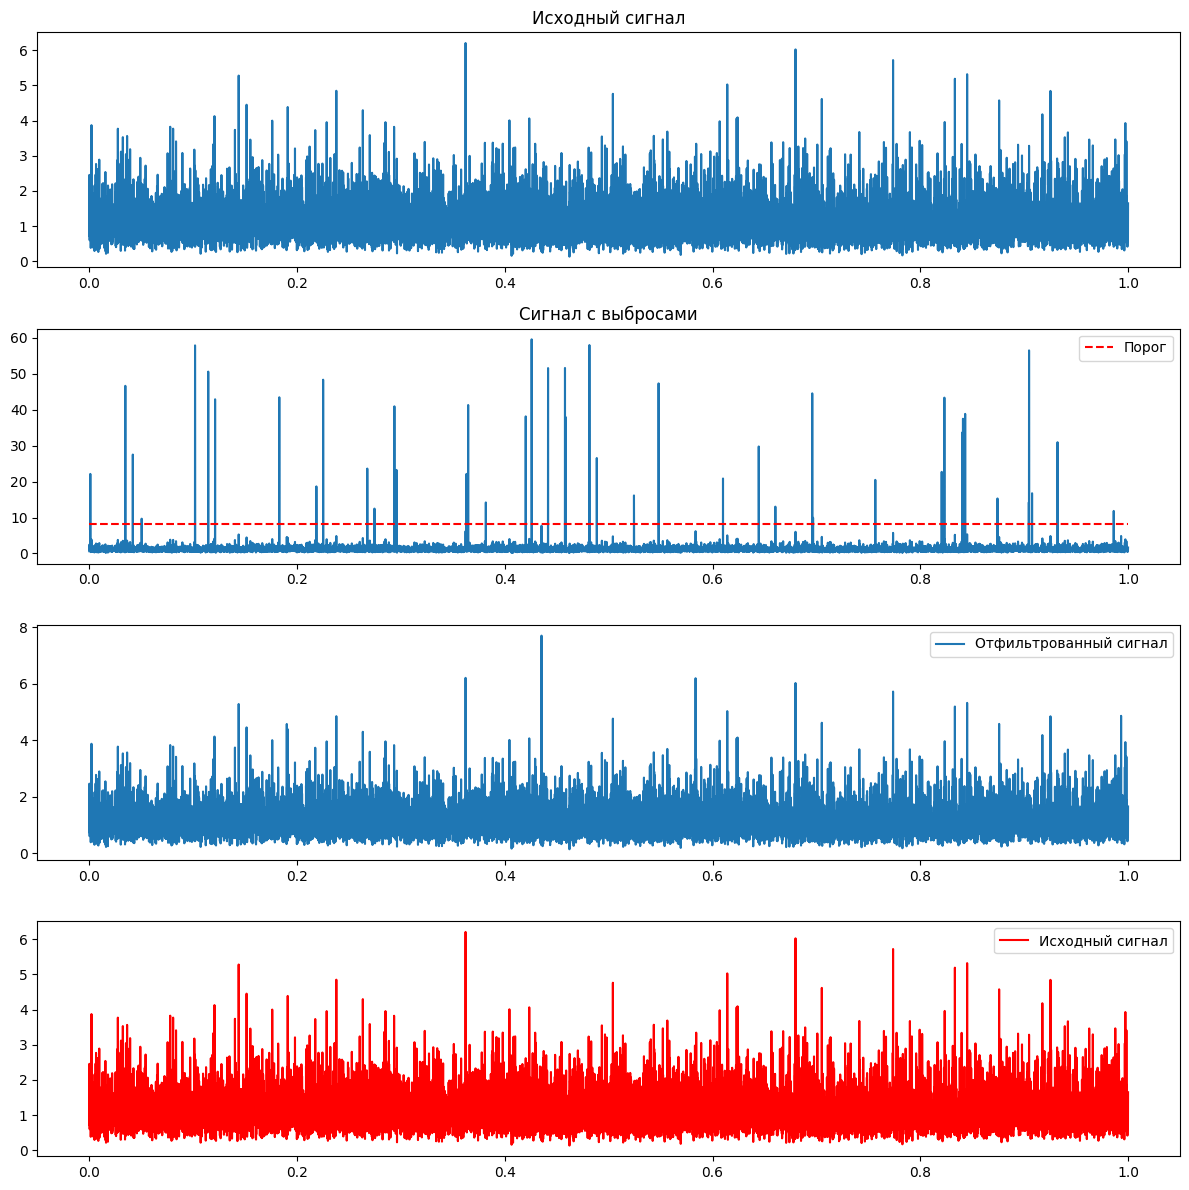

In [6]:
N = 10000
time = np.linspace(0, 1, N)
signal1 = np.exp(0.5 * np.random.randn(N))
signal2 = np.array(signal1)

n = 50
outliers = np.random.randint(0, N, n)
signal2[outliers] = np.random.rand(n) * (np.max(signal1) - np.min(signal1)) * 10

threshold = np.mean(signal2) + 3 * np.std(signal2)

# signal_filtered = signal2[signal2 < threshold]
signal_filtered = np.array([t if t < threshold else -100 for t in signal2])

bad_indices = np.where(signal_filtered == -100)[0].tolist()
good_indices = np.where(signal_filtered != -100)[0].tolist()

interpolator = interp1d(good_indices, signal_filtered[good_indices], kind='linear', fill_value="extrapolate")
signal_filtered[bad_indices] = interpolator(bad_indices)

print(f"{len(bad_indices)} выброса отфильтровано")

plt.figure(figsize=(12, 12))

plt.subplot(4, 1, 1)
plt.plot(time, signal1)
plt.title("Исходный сигнал")

plt.subplot(4, 1, 2)
plt.plot(time, signal2)
plt.plot([time[0], time[-1]], [threshold, threshold], 'r--', label="Порог")
plt.title("Сигнал с выбросами")
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(time, signal_filtered, label="Отфильтрованный сигнал")
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(time, signal1, 'r', label="Исходный сигнал")
plt.legend()


plt.tight_layout()
plt.show()

### Задание 2
Реализовать сигнал, который содержит области с высоким уровнем шума, рис.3. Это может быть сделано путем добавления случайного шума к основному сигналу в определенных интервалах времени.

Напишите метод для очистки сигнала с помощью оконного скользящего среднеквадратичного отклонения (Outlier time windows via sliding RMS), рис. 4.

![Рисунок 3](pics/lab_7/outlier_3.png)
![Рисунок 4](pics/lab_7/outlier_4.png)

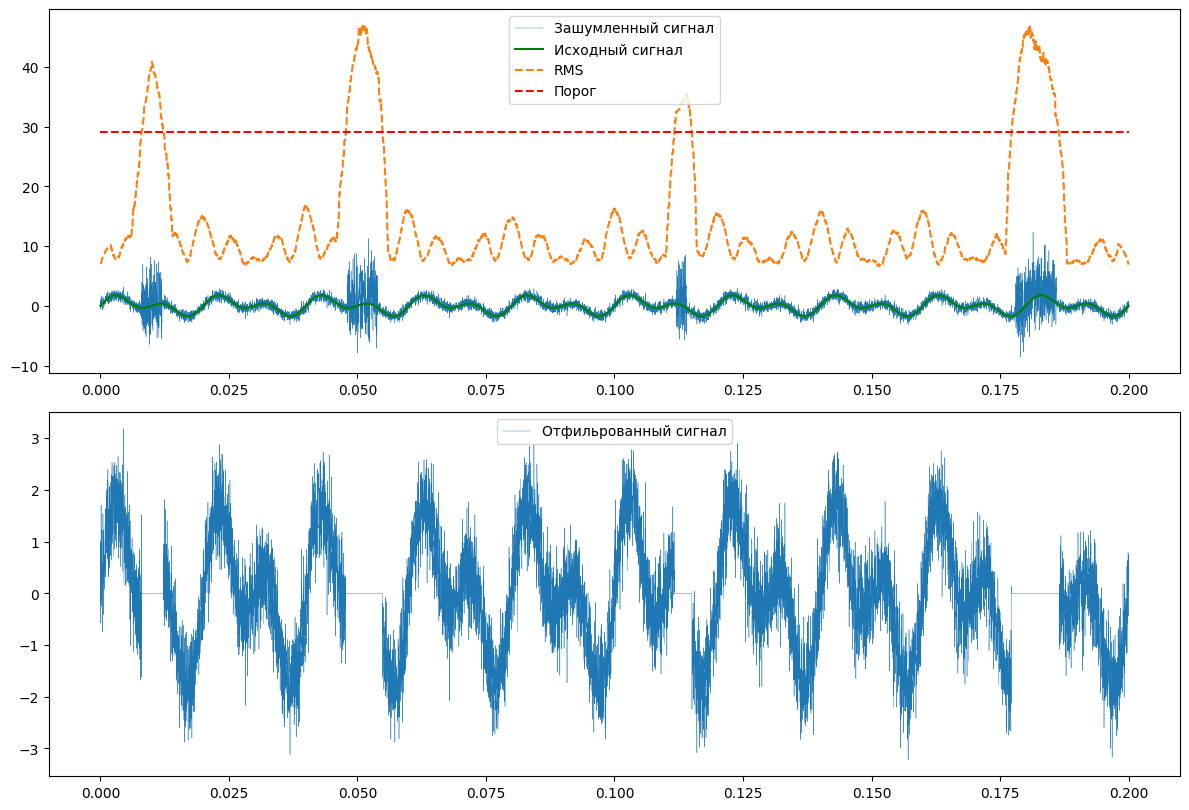

In [7]:
signal = lambda t: np.sin(50 * 2 * np.pi * t) + np.sin(100 * 2 * np.pi * t)
noised_signal = lambda t: t + np.random.normal(0, 0.5, len(t))
loud_noise = lambda t, i, j: np.concatenate((t[:i], t[i:j] + np.random.normal(1, 3, j-i), t[j:]), axis=0)

N = 10000
time_0 = 0
time_1 = 0.2
step = (time_1 - time_0) / N

x = np.linspace(time_0, time_1, N)
y = signal(x)
y_noised_base = noised_signal(y)
y_noised = loud_noise(loud_noise(loud_noise(loud_noise(y_noised_base, 400, 600), 2400, 2700), 5600, 5700), 8900, 9300)

# y_mean_plus = np.mean(y_noised) + 3 * np.std(y_noised)
# y_mean_minus = np.mean(y_noised) - 3 * np.std(y_noised)

window_size = 2
k = int(N * (window_size/2/100))

rms_threshold = np.zeros(N)
threshold = 29

for i in range(0, N):
    lower_bound = np.max((0, i-k))
    upper_bound = np.min((i+k, N))
    tmpsig = y_noised[range(lower_bound, upper_bound)]
    tmpsig = tmpsig - np.mean(tmpsig)
    rms_threshold[i] = np.sqrt(np.sum(tmpsig**2))
    
filtered_low = np.array(y_noised)
filtered_up = np.array(y_noised)

filtered_low[np.where(rms_threshold < threshold)[0].tolist()] = 0
filtered_up[np.where(rms_threshold > threshold)[0].tolist()] = 0

plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
plt.plot(x, y_noised, lw=0.3, label="Зашумленный сигнал")
plt.plot(x, y, 'g', label="Исходный сигнал")
plt.plot(x, rms_threshold, '--', label='RMS')
plt.plot([x[0], x[-1]], [threshold, threshold], 'r--', label="Порог")
plt.legend(loc="upper center")

plt.subplot(3, 1, 2)
plt.plot(x, filtered_up, lw=0.3, label="Отфильрованный сигнал")
# plt.plot(x, filtered_low, "r", lw=0.3, label="Сильный шум")
plt.legend(loc="upper center")

plt.tight_layout()
plt.show()

### Задание 3
Метод спектральной интерполяции сигналов. Данный метод позволяет восстановить часть сигнала, которая была потеряна или удалена.

Алгоритм реализации метода:

- Для реализации метода рассмотрите сигнал, в котором Вы уже удалили часть сигнала. Необходимо восстановить потерянную часть сигнала с помощью спектральной интерполяции.
- Задать размер окна по временной области для которых будет определяться спектр. Размер окон для правой и левой части должны совпадать.
- Определить спектр сигнала до разрыва и после разрыва.
- Осуществить усреднение спектров сигналов в правой и левой области.
- С помощью обратного преобразования Фурье восстановить утерянную часть сигнала.
- Сшить границы с помощью линейной интерполяции.

![Рисунок 5](pics/lab_7/outlier_5.png)

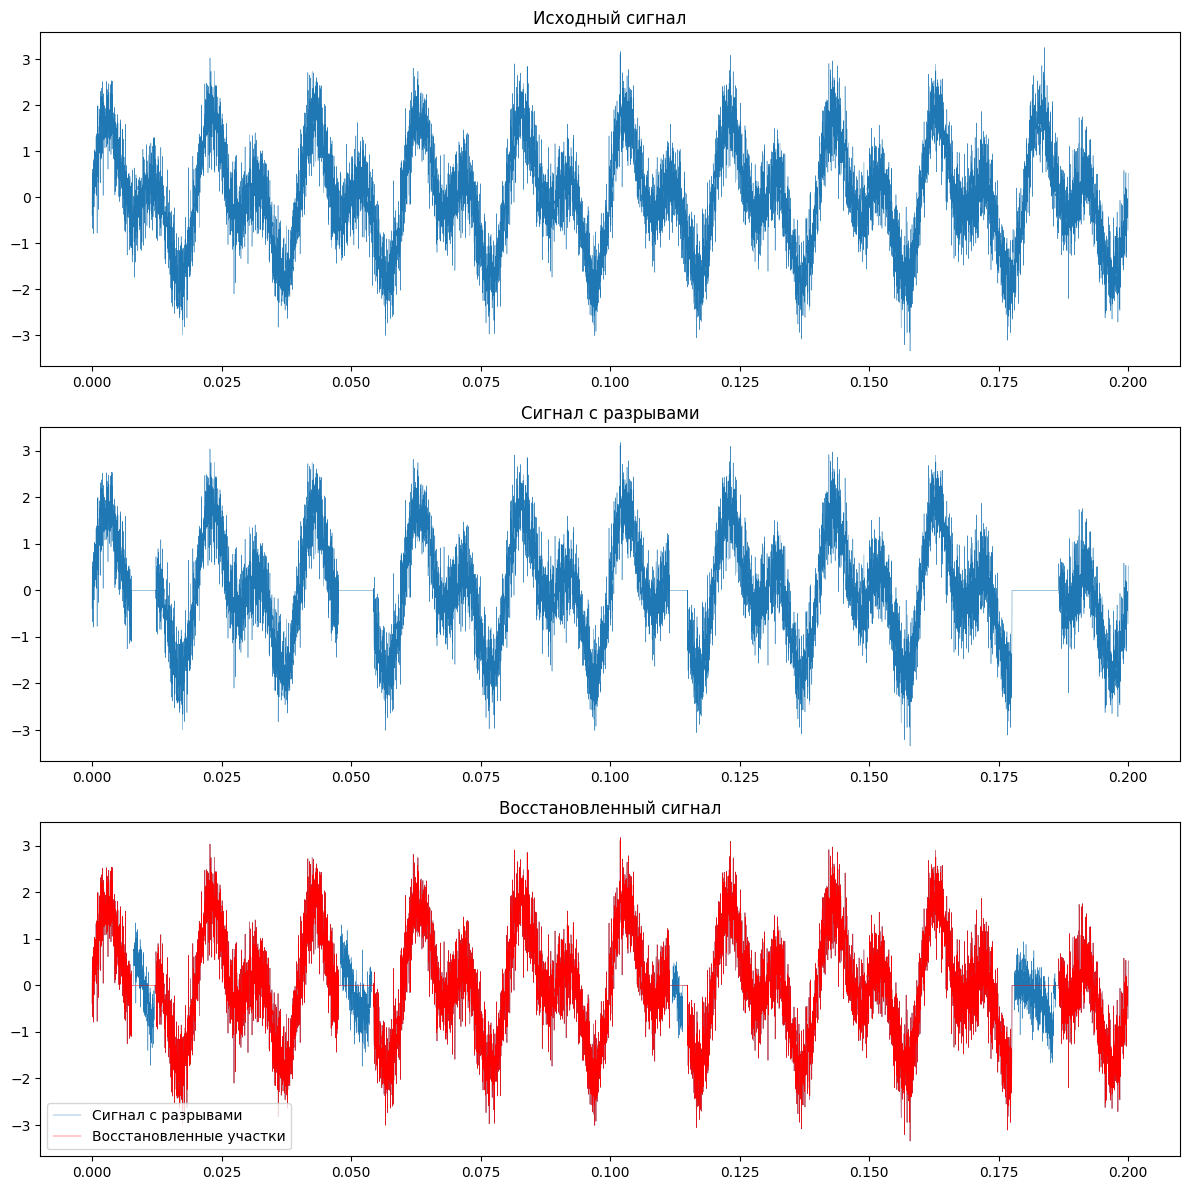

In [120]:
def spectral_interpolation(signal, gap_start, gap_end, window_size):
    left_window = signal[gap_start - window_size:gap_start]
    right_window = signal[gap_end:gap_end + window_size]

    left_spectrum = np.fft.fft(left_window)
    right_spectrum = np.fft.fft(right_window)
    avg_spectrum = (left_spectrum + right_spectrum) / 2

    restored_gap = np.real(np.fft.ifft(avg_spectrum))

    x_interp = np.arange(gap_start, gap_end)
    interp_start = restored_gap[0]
    interp_end = restored_gap[-1]
    linear_interp = np.linspace(interp_start, interp_end, len(x_interp))

    restored_signal = signal.copy()
    # restored_signal[gap_start:gap_end] = restored_gap + (linear_interp - restored_gap)
    restored_signal[gap_start:gap_end] = restored_gap 

    return restored_signal


window_sizes = [200, 300, 100, 400]
gaps = [(400, 600), (2400, 2700), (5600, 5700), (8900, 9300)]
restored_signal = np.copy(filtered_up)
for i in range(len(gaps)):
    restored_signal = spectral_interpolation(restored_signal, gaps[i][0], gaps[i][1], window_sizes[i])
    
plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
plt.plot(x, y_noised_base, lw=0.3)
plt.title("Исходный сигнал")

plt.subplot(3, 1, 2)
plt.plot(x, filtered_up, lw=0.3)
plt.title("Сигнал с разрывами")

plt.subplot(3, 1, 3)
plt.plot(x, restored_signal, lw=0.3, label="Сигнал с разрывами")
plt.plot(x, filtered_up, 'r', lw=0.3, label="Восстановленные участки")
plt.title("Восстановленный сигнал")
plt.legend()

plt.tight_layout()
plt.show()

### Задание 4
Алгоритм понижения/повышения дискретности сигнала в N раз.

Понижение дискретности сигнала можно осуществить двумя методами:

(а) уменьшением числа точек в сигнале в N раз (неправильный). Замечание: для увеличения
дискретности сигнала данным способом можно воспользоваться и он будет правильным.

(б) уменьшением дискретности сигнала в N раз (правильный) с помощью определения новой частоты
Найквиста, которая будет соответствовать новой дискретности сигнала.

Понижение дискретности сигнала осуществляется в три этапа, рис. 6. В качестве исходного сигнала
можно выбрать сигнал косинуса с двумя частотами, например, 50 и 100 Гц.

![Рисунок 6_1](pics/lab_7/outlier_6_1.png)
![Рисунок 6_2](pics/lab_7/outlier_6_2.png)

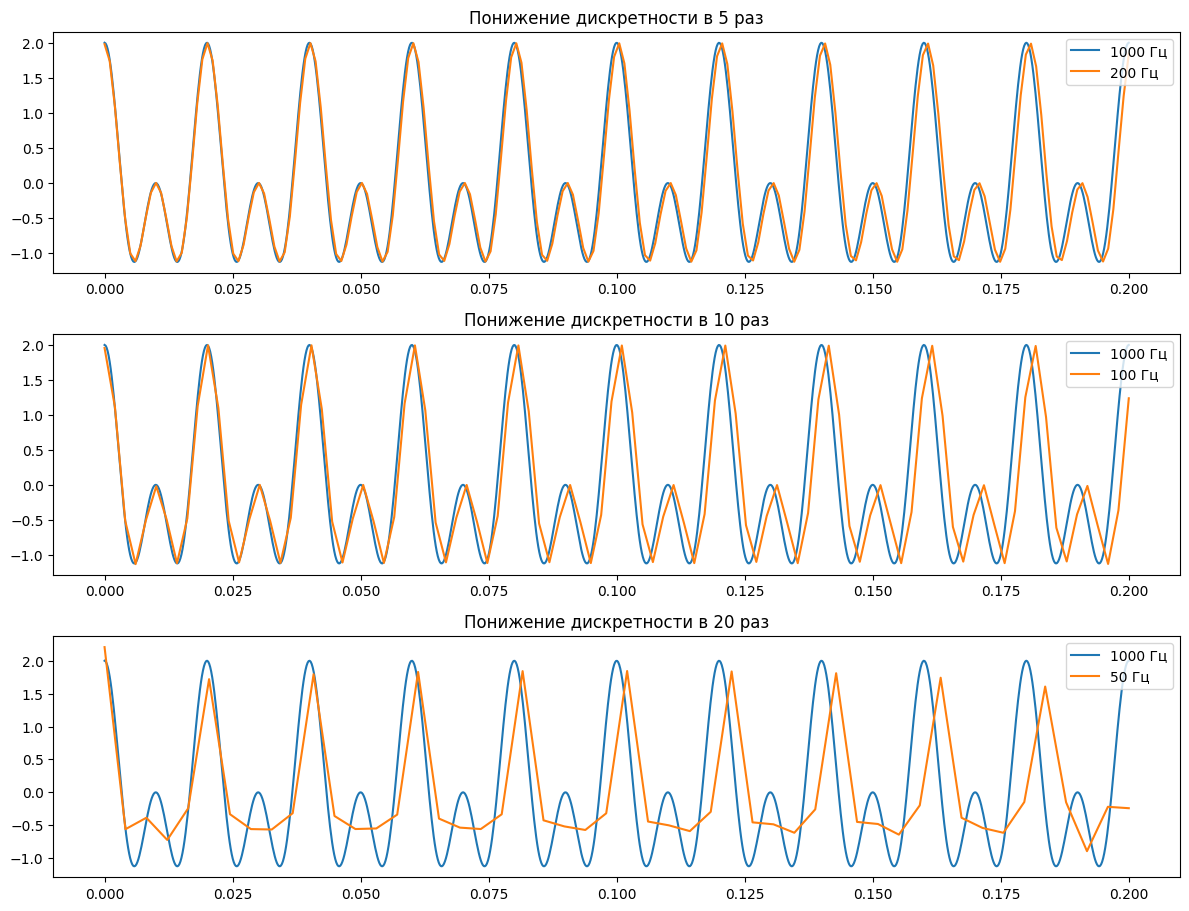

In [156]:
signal = lambda t: np.cos(50 * 2 * np.pi * t) + np.cos(100 * 2 * np.pi * t)

def downsample_signal(signal, fs, N):
    fs_new = fs / N

    nyquist_new = fs_new / 2
    b, a = butter(4, nyquist_new / (fs / 2), btype='low')
    signal_filtered = filtfilt(b, a, signal)

    signal_down = decimate(signal_filtered, N)

    return signal_down, fs_new


N = 1000
downscale_1 = 5
downscale_2 = 10
downscale_3 = 20

x = np.linspace(0, 0.2, N)
y = signal(x)

signal_down_1, fs_new_1 = downsample_signal(y, N, downscale_1)
signal_down_2, fs_new_2 = downsample_signal(y, N, downscale_2)
signal_down_3, fs_new_3 = downsample_signal(y, N, downscale_3)

x_down_1 = np.linspace(0, 0.2, N // downscale_1)
x_down_2 = np.linspace(0, 0.2, N // downscale_2)
x_down_3 = np.linspace(0, 0.2, N // downscale_3)

plt.figure(figsize=(12, 12))

plt.subplot(4, 1, 1)
plt.plot(x, y, label=f"{N} Гц")
plt.plot(x_down_1, signal_down_1, label=f"{N // downscale_1} Гц")
plt.legend(loc="upper right")
plt.title(f"Понижение дискретности в {downscale_1} раз")

plt.subplot(4, 1, 2)
plt.plot(x, y, label=f"{N} Гц")
plt.plot(x_down_2, signal_down_2, label=f"{N // downscale_2} Гц")
plt.legend(loc="upper right")
plt.title(f"Понижение дискретности в {downscale_2} раз")

plt.subplot(4, 1, 3)
plt.plot(x, y, label=f"{N} Гц")
plt.plot(x_down_3, signal_down_3, label=f"{N // downscale_3} Гц")
plt.legend(loc="upper right")
plt.title(f"Понижение дискретности в {downscale_3} раз")

plt.tight_layout()
plt.show()

### Задание 5
В результате записи сигналов с 3-х различных датчиков были записаны данные с различной частотой дискретизации, рис 7 (а).

Привести все сигналы к единой частоте дискретизации, как представлено на рис. 7 (б). 

В качестве сигналов можно выбрать три косинуса с различной частотой дискретизации, например 10, 35 и 80 Гц.

![Рисунок 7a](pics/lab_7/outlier_7_a.png)
![Рисунок 7b](pics/lab_7/outlier_7_b.png)

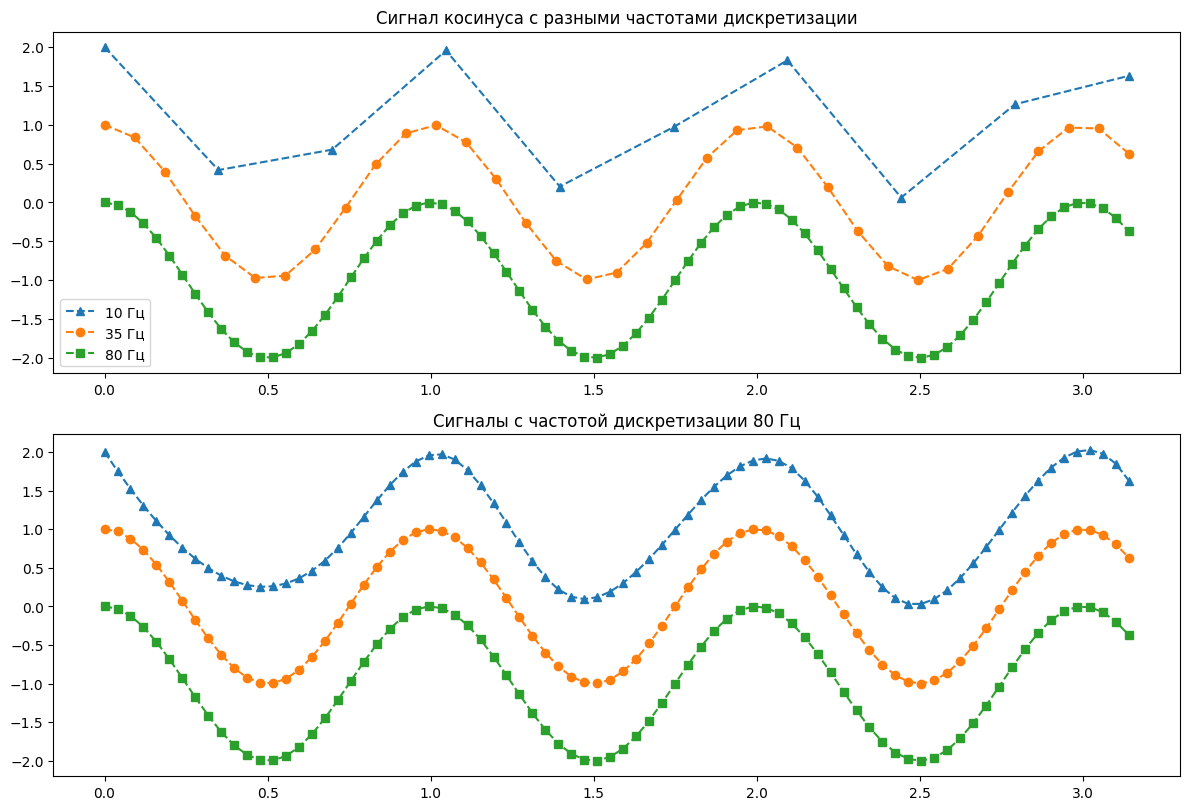

In [188]:
signal = lambda t, y: np.cos(2 * np.pi * t) + y

N1, N2, N3 = 10, 35, 80

x_1 = np.linspace(0, np.pi, N1)
x_2 = np.linspace(0, np.pi, N2)
x_3 = np.linspace(0, np.pi, N3)

y_1 = signal(x_1, 1)
y_2 = signal(x_2, 0)
y_3 = signal(x_3, -1)

fs_common = 80
x = np.linspace(0, np.pi, fs_common)

y_1_int = interp1d(x_1, y_1, kind="cubic")
y_2_int = interp1d(x_2, y_2, kind="cubic")
y_3_int = interp1d(x_3, y_3, kind="cubic")

y_1_resampled = y_1_int(x)
y_2_resampled = y_2_int(x)
y_3_resampled = y_3_int(x)

plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
plt.plot(x_1, y_1, '^--', label="10 Гц")
plt.plot(x_2, y_2, 'o--', label="35 Гц")
plt.plot(x_3, y_3, 's--', label="80 Гц")
plt.title("Сигнал косинуса с разными частотами дискретизации")
plt.legend(loc="lower left")

plt.subplot(3, 1, 2)
plt.plot(x, y_1_resampled, '^--')
plt.plot(x, y_2_resampled, 'o--')
plt.plot(x, y_3_resampled, 's--')
plt.title("Сигналы с частотой дискретизации 80 Гц")

plt.tight_layout()
plt.show()